# Parte 2

Primeiramente as amostras do arquivo *mackeyglass.csv* foram formatadas para $K = 10$ e $L = 7$, utilizando a função **Entrada_Saida**. Após isso os atributos originais de entrada foram transformados utilizando a função **Transforma_Entrada**. Os parâmetros aleatórios foram escolhidos entre o intervalo $[-2, 2)$. Outros intervalos foram testados partindo-se de $[-0.5, 0.5)$ até $[10, 10)$ e o utilizado foi o que produziu o melhor resultado em termos de RMSE. A transformação foi feita para $V$ variando de $10$ até $1000$, com passos de $10$ em $10$. Os atributos foram empilhados horizontalmente e guardados na variável $x\_linhas$. Finalmente, os novos atributos foram dividos em aproximação, validação e teste como na parte 1.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mg_df = pd.read_csv('mackeyglass.csv')

#Preparação dos dados de entrada e saída.
def Entrada_Saida(K, L):
    x = np.zeros([1, K])
    y = np.zeros([1])
    for i in range(len(P)-K-L+1):
        xr = np.array([])
        for j in range(K):
            xr = np.append(xr, P[i+j])
        x = np.vstack((x, xr))
        y = np.vstack((y, P[i+K+L-1]))
    x = x[1:len(x)]
    y = y[1:len(y)]
    return(x, y)

def Transforma_Entrada(x, V):
    XX_linha = np.zeros([len(x), 1])
    for v in range(V):
        wk = np.random.uniform(-2, 2, 10)
        X_linha = []    
        for i in range(len(x)):
            x_r = x[i, :]
            x_linha = np.tanh(np.dot(wk, x_r)) 
            X_linha.append(x_linha)      
        X_linha = np.reshape(X_linha, (len(X_linha), 1))
        XX_linha = np.hstack((XX_linha, X_linha))
    XX_linha = XX_linha[:, 1:len(XX_linha[0])]
    return XX_linha 


P = mg_df.p.values

K = 10
L = 7
(x, y) = Entrada_Saida(K, L)

ranw = 101

x_linhas = np.zeros([len(x), 1])
for V in range(1, ranw, 1):  
    x_linha = Transforma_Entrada(x, V*10)      
    x_linhas = np.hstack((x_linhas, x_linha))
x_linhas = x_linhas[:, 1:len(x_linhas[0])]

#A 10 primeiras colunas de x_linhas contém os atributos transformados para V = 10, as próximas 20 linhas contém
#os atributos transformados para V = 20, e assim por diante.   

#Separação entre dados de teste e dados de validação
x_linhas_teste = x_linhas[int(0.75*len(x_linhas)):len(x_linhas)]
y_teste = y[int(0.75*len(y)):len(y)]

x_linhas_treino = x_linhas[0:int(0.75*len(x_linhas))]
y_treino = y[0:int(0.75*len(y))]

#Separação das amostras que vão ser efeitivamente utilizadas para a aproximação e as amostras para validação
x_linhas_aprox = x_linhas_treino[0:int(0.7*len(x_linhas_treino))]
y_aprox = y_treino[0:int(0.7*len(y_treino))]

x_linhas_valid =  x_linhas_treino[int(0.7*len(x_linhas_treino)):len(x_linhas_treino)]
y_valid =  y_treino[int(0.7*len(y_treino)):len(y_treino)]


Em sequência foi realizada a etapa de treinamento. Para isso a função **Calcula_Param** foi usada para realizar o computo dos parâmetros, para cada conjunto de atributos gerados na etapa anterior, segundo o critério de mínimos quadrados. Além disso foi adicionado um termo de penalização proporcional à norma euclidiana do vetor de parâmetros, técnica conhecida como *Ridge Regression*. O valor inicial testado para a constante foi de $\lambda  = 1$ e diminuindo o valor por um fator de $10$ foi observado que era possível atingir um resultado melhor em termos de $RMSE$ até $\lambda  = 0.000000001$, quando então a $RMSE$ começava a crescer. Os parâmetros gerados para cada lote de atributos foram armazenados na variável $W$.

In [2]:
#Treinamento

def Calcula_Param(x, y, lamb):
    temp = np.ones((len(x), 1))
    fi = np.concatenate((temp, x), axis = 1)
    aux = np.matmul(fi.T, fi) 
    z = np.zeros(len(aux)-1)
    I = np.eye(len(aux)-1)
    I_linha = np.vstack((z, I)) 
    z = np.zeros(len(I_linha))
    z = np.reshape(z, [len(z), 1])
    I_linha = np.hstack((z, I_linha))                                                                                                                                            
    aux = aux + lamb*I_linha
    FI = np.matmul(np.linalg.inv(aux), fi.T)
    w = np.matmul(FI, y)
    return (w)
    
indice_antes = 0
indice_depois = 10

W = np.zeros([1001, 1])
for V in range (1, ranw, 1):
        
    x_linha_aprox_desempacotado = x_linhas_aprox[:, indice_antes : indice_depois]
    
    indice_antes = indice_antes + 10*V
    indice_depois = indice_depois + 10*(V+1)    
    
    w = Calcula_Param(x_linha_aprox_desempacotado, y_aprox, 0.000000001)
    Completa_w = np.zeros([1001-len(w), 1])
    w = np.vstack((w, Completa_w))
    W = np.hstack((W,w))
    

Seguiu-se a etapa de validação. A função **Desempacota_Parametros** foi utilizada para extrair o vetor de parâmetros calculado para cada $V$. Em seguida, de maneira muito similar à parte 1 as saídas foram calculadas e utilizando o valor esperado a $RMSE$ foi calculada. Em seguida o gráfico de $RMSE$ por $V$, foi gerado. É possível observar pelo gráfico que ocorre um decaimento similar a uma exponencial na medida em que V aumenta. De fato isso ficou mais evidente para valores maiores de $\lambda$ utilizados no treinamento. Para o $\lambda$ utilizado, valores mais altos de $V$ resultam em uma oscilação no gráfico. Porém, o $\lambda$ utilizado foi o que proporcionou a menor $RMSE$, sendo mais baixa inclusive que a encontrada na parte 1.

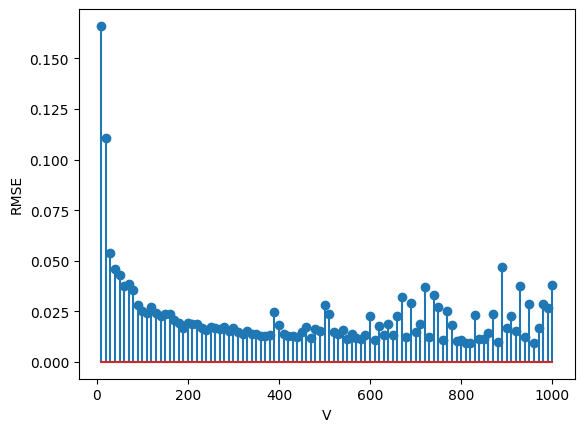

In [3]:
#Validação
def Desempacota_Parametros(V, W):
    w = W[:, V]
    w = w[0:10*V+1]
    w = np.reshape(w, (len(w), 1))
    return w

def Calcula_Saidas(x_valid, w):
    Y = []
    for i in range(len(x_valid)):
        x = np.array([1])
        x = np.append(x, x_valid[i])        
        x = np.reshape(x, (len(x), 1))
        y_calc = np.dot(w.T,x)  
        y_calc = np.ndarray.tolist(y_calc[0])
        y_esperado = y_valid[i]
        Y.append((y_calc[0], y_esperado))
    return(Y)

def Calcula_RMSE(Y):
    e = 0
    for y in Y:
        y_calc, y_esp = y
        e += (y_calc - y_esp)**2
    e = e/len(Y)
    e = e**(1/2)
    return e

    
indice_antes = 0
indice_depois = 10

E = []
Vs = []

for V in range (1, len(W[0])):
    w = Desempacota_Parametros(V, W)
    x_linha_valid_desempacotado = x_linhas_valid[:, indice_antes : indice_depois]

    indice_antes = indice_antes + 10*V
    indice_depois = indice_depois + 10*(V+1)
    
    Y = Calcula_Saidas(x_linha_valid_desempacotado, w)  
    E.append(Calcula_RMSE(Y))
    Vs.append(10*V)

fig, ax = plt.subplots()
ax.stem(Vs, E)
ax.set_ylabel('RMSE')
ax.set_xlabel('V')
plt.show()


Para a última etapa de teste foram utilizados os parâmetros calculados para $V = 960$ - Notar que o $V$ de fato utilizado no código foi $96$, já que esta variável crescia em passos de $10$. Este foi o $V$ que gerou o menor erro, $RMSE = 0.0093$. Com o auxílio da função **Calcula_saidas_teste** os gráficos das saídas calculadas - em vermelho - e esperadas - em azul - foi gerado. Como aguardado, o desempenho do modelo da parte 2 foi ainda melhor do que o modelo utilizado na parte 1, podendo-se observar uma menor distorção nos picos da série calculada em comparação com a série esperada. Isso foi possibilitado por conta da transformação não linear realizada na geração dos novos atributos.

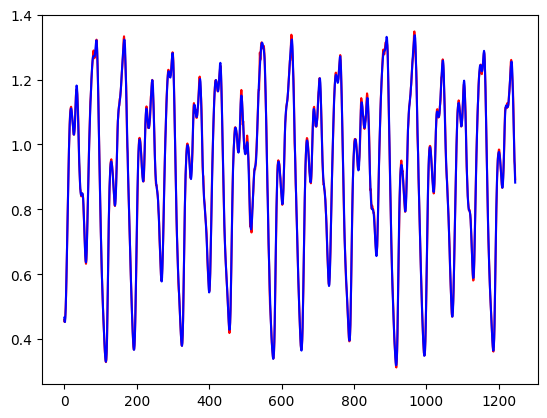

In [11]:
#Comparação com amostras de teste para V = 96
def Calcula_Saidas_teste(x_teste, w):
    Y_esp = []
    Y_calc = []
    for i in range(len(x_teste)):
        x = np.array([1])
        x = np.append(x, x_teste[i])
        x = np.reshape(x, (len(x), 1))
        y_calc = np.dot(w.T,x)
        Y_calc = np.append(Y_calc, y_calc)
        Y_esp = np.append(Y_esp, y_teste[i])
    return Y_calc, Y_esp


V = 96
w = Desempacota_Parametros(V, W)

indice_antes = 0
indice_depois = 10
for i in range(1, V, 1):
    indice_antes = indice_antes + 10*i
    indice_depois = indice_depois + 10*(i+1)
    


x_linha_teste_desempacotado = x_linhas_teste[:, indice_antes : indice_depois]

y_calculado, y_esperado = Calcula_Saidas_teste(x_linha_teste_desempacotado, w)

t = np.arange(len(y_calculado))
fig, bx = plt.subplots()
bx.plot(t, y_calculado, color = "red")
bx.plot(t, y_esperado, color = "blue")
plt.show()
